In [1]:
%matplotlib inline
# 导入需要的包
import paddle
import numpy as np
from paddle.nn import Conv2D, MaxPool2D, Linear,Dropout

## 组网
import paddle.nn.functional as F

import json
import gzip
import paddle

# -*- coding: utf-8 -*-
# LeNet 识别手写数字
import os
import random
import paddle
import numpy as np
import paddle.nn as nn
from paddle.vision.transforms import ToTensor
# from paddle.vision.datasets import MNIST
import matplotlib.pyplot as plt
from IPython import display


import logging
logger = logging.getLogger('simple_example')
logger.setLevel(logging.DEBUG)


In [2]:
# 定义 LeNet 网络结构
class LeNet(paddle.nn.Layer):
    def __init__(self, num_classes=1):
        super(LeNet, self).__init__()
        # 创建卷积和池化层
        # 创建第1个卷积层
        self.conv1 = Conv2D(in_channels=1, out_channels=6, kernel_size=5)
        self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
        # 尺寸的逻辑：池化层未改变通道数；当前通道数为6
        # 创建第2个卷积层
        self.conv2 = Conv2D(in_channels=6, out_channels=16, kernel_size=5)
        self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
        # 创建第3个卷积层
        self.conv3 = Conv2D(in_channels=16, out_channels=120, kernel_size=4)
        # 尺寸的逻辑：输入层将数据拉平[B,C,H,W] -> [B,C*H*W]
        # 输入size是[28,28]，经过三次卷积和两次池化之后，C*H*W等于120
        self.fc1 = Linear(in_features=120, out_features=64)
        # 创建全连接层，第一个全连接层的输出神经元个数为64， 第二个全连接层输出神经元个数为分类标签的类别数
        self.fc2 = Linear(in_features=64, out_features=num_classes)
    # 网络的前向计算过程
    def forward(self, x):
        x = self.conv1(x)
        # 每个卷积层使用Sigmoid激活函数，后面跟着一个2x2的池化
        x = F.sigmoid(x)
        x = self.max_pool1(x)
        x = F.sigmoid(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = self.conv3(x)
        # 尺寸的逻辑：输入层将数据拉平[B,C,H,W] -> [B,C*H*W]
        x = paddle.reshape(x, [x.shape[0], -1])
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        return x

In [3]:
class MnistDataset(paddle.io.Dataset):
    def __init__(self, mode):
        super().__init__()
        datafile = '../work/mnist.json.gz'
        data = json.load(gzip.open(datafile))
        # 读取到的数据区分训练集，验证集，测试集
        train_set, val_set, eval_set = data

        # 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
        self.IMG_ROWS = 28
        self.IMG_COLS = 28

        if mode == 'train':
            # 获得训练数据集
            imgs, labels = train_set[0], train_set[1]
        elif mode == 'valid':
            # 获得验证数据集
            imgs, labels = val_set[0], val_set[1]
        elif mode == 'eval':
            # 获得测试数据集
            imgs, labels = eval_set[0], eval_set[1]
        else:
            raise Exception("mode can only be one of ['train', 'valid', 'eval']")

        # 校验数据
        imgs_length = len(imgs)
        assert len(imgs) == len(labels), \
            "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(labels))

        self.imgs = imgs
        self.labels = labels

    def __getitem__(self, idx):
        # img = np.array(self.imgs[idx]).astype('float32')
        # label = np.array(self.labels[idx]).astype('int64')
        img = np.reshape(self.imgs[idx], [1, self.IMG_ROWS, self.IMG_COLS]).astype('float32')
        label = np.reshape(self.labels[idx], [1]).astype('int64')

        return img, label

    def __len__(self):
        return len(self.imgs)

In [20]:
def train(model, bs=20, es=10, model_name='mnist.pdparams'):
    use_gpu = True
    paddle.device.set_device('gpu:0') if use_gpu else paddle.device.set_device('cpu')
    # 声明数据加载函数，使用训练模式，MnistDataset构建的迭代器每次迭代只返回batch=1的数据
    train_dataset = MnistDataset(mode='train')
    # 使用paddle.io.DataLoader 定义DataLoader对象用于加载Python生成器产生的数据，
    # DataLoader 返回的是一个批次数据迭代器，并且是异步的；
    train_loader = paddle.io.DataLoader(train_dataset, batch_size=bs, shuffle=True, drop_last=True)
    val_dataset = MnistDataset(mode='valid')
    val_loader = paddle.io.DataLoader(val_dataset, batch_size=bs, drop_last=True)
    logger.info('load dataset finished, start train')
    model.train()
    # 调用加载数据的函数
    # train_loader = load_data('train')
    # val_loader = load_data('valid')
    opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    # EPOCH_NUM = 100
    x = []
    y1 = []
    y2 = []
    y3 = []
    plt.figure('train')
    plt.ion()
    for epoch_id in range(es):
        x.append(epoch_id)
        for batch_id, data in enumerate(train_loader()):
            # 准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            # 前向计算的过程
            predicts = model(images)

            # 计算损失，使用交叉熵损失函数，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)

            # 每训练了200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                   logger.info('epoch:%s, batch:%s, loss:%s', epoch_id, batch_id, float(avg_loss))
                # print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.item()))

            # 后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()
        acc_train_mean = evaluation(model, train_loader)
        acc_val_mean = evaluation(model, val_loader)
        logger.info('train_acc:%s, val_acc:%s', acc_train_mean, acc_val_mean)
        plt.clf()  # 清除之前画的图
        y2.append(acc_train_mean)
        y3.append(acc_val_mean)     
        # plt.plot(x, y2 * np.array([1]), label='train_acc')
        # plt.plot(x, y3 * np.array([1]), label='val_acc')
        plt.plot(x, y2 * np.array([1]))
        plt.plot(x, y3 * np.array([1]))
        plt.pause(0.001)  # 暂停一段时间，不然画的太快会卡住显示不出来
        display.clear_output(wait=True)
        plt.ioff()  # 关闭画图窗口
        # print('train_acc: {}, val_acc: {}'.format(acc_train_mean, acc_val_mean))
    # 保存模型参数
    paddle.save(model.state_dict(), model_name)

In [5]:
def evaluation(model, datasets):
    model.eval()

    acc_set = list()
    for batch_id, data in enumerate(datasets()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        pred = model(images)  # 获取预测值
        acc = paddle.metric.accuracy(input=pred, label=labels)
        # t = acc.numpy()
        # f = float(acc)
        acc_set.append(float(acc))
        # acc_set.extend(acc.numpy())
        # print(type(acc))
        # acc_set.extend(float(acc))

    # #计算多个batch的准确率
    acc_val_mean = np.array(acc_set).mean()
    return acc_val_mean

## 以上为leNet,以下为alexNet

In [6]:
# 定义 AlexNet 网络结构
class AlexNet(paddle.nn.Layer):
    def __init__(self, num_classes=1):
        super(AlexNet, self).__init__()
        # AlexNet与LeNet一样也会同时使用卷积和池化层提取图像特征
        # 与LeNet不同的是激活函数换成了‘relu’
        self.conv1 = Conv2D(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=5)
        self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
        self.conv2 = Conv2D(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
        self.conv3 = Conv2D(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv4 = Conv2D(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = Conv2D(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.max_pool5 = MaxPool2D(kernel_size=2, stride=2)

        self.fc1 = Linear(in_features=12544, out_features=4096)
        self.drop_ratio1 = 0.5
        self.drop1 = Dropout(self.drop_ratio1)
        self.fc2 = Linear(in_features=4096, out_features=4096)
        self.drop_ratio2 = 0.5
        self.drop2 = Dropout(self.drop_ratio2)
        self.fc3 = Linear(in_features=4096, out_features=num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.max_pool5(x)
        x = paddle.reshape(x, [x.shape[0], -1])
        x = self.fc1(x)
        x = F.relu(x)
        # 在全连接之后使用dropout抑制过拟合
        x = self.drop1(x)
        x = self.fc2(x)
        x = F.relu(x)
        # 在全连接之后使用dropout抑制过拟合
        x = self.drop2(x)
        x = self.fc3(x)
        return x

## 以下为resNet

In [7]:
# ResNet中使用了BatchNorm层，在卷积层的后面加上BatchNorm以提升数值稳定性
# 定义卷积批归一化块
class ConvBNLayer(paddle.nn.Layer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 filter_size,
                 stride=1,
                 groups=1,
                 act=None):

        """
        num_channels, 卷积层的输入通道数
        num_filters, 卷积层的输出通道数
        stride, 卷积层的步幅
        groups, 分组卷积的组数，默认groups=1不使用分组卷积
        """
        super(ConvBNLayer, self).__init__()

        # 创建卷积层
        self._conv = nn.Conv2D(
            in_channels=num_channels,
            out_channels=num_filters,
            kernel_size=filter_size,
            stride=stride,
            padding=(filter_size - 1) // 2,
            groups=groups,
            bias_attr=False)

        # 创建BatchNorm层
        self._batch_norm = paddle.nn.BatchNorm2D(num_filters)

        self.act = act

    def forward(self, inputs):
        y = self._conv(inputs)
        y = self._batch_norm(y)
        if self.act == 'leaky':
            y = F.leaky_relu(x=y, negative_slope=0.1)
        elif self.act == 'relu':
            y = F.relu(x=y)
        return y


# 定义残差块
# 每个残差块会对输入图片做三次卷积，然后跟输入图片进行短接
# 如果残差块中第三次卷积输出特征图的形状与输入不一致，则对输入图片做1x1卷积，将其输出形状调整成一致
class BottleneckBlock(paddle.nn.Layer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 stride,
                 shortcut=True):
        super(BottleneckBlock, self).__init__()
        # 创建第一个卷积层 1x1
        self.conv0 = ConvBNLayer(
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=1,
            act='relu')
        # 创建第二个卷积层 3x3
        self.conv1 = ConvBNLayer(
            num_channels=num_filters,
            num_filters=num_filters,
            filter_size=3,
            stride=stride,
            act='relu')
        # 创建第三个卷积 1x1，但输出通道数乘以4
        self.conv2 = ConvBNLayer(
            num_channels=num_filters,
            num_filters=num_filters * 4,
            filter_size=1,
            act=None)

        # 如果conv2的输出跟此残差块的输入数据形状一致，则shortcut=True
        # 否则shortcut = False，添加1个1x1的卷积作用在输入数据上，使其形状变成跟conv2一致
        if not shortcut:
            self.short = ConvBNLayer(
                num_channels=num_channels,
                num_filters=num_filters * 4,
                filter_size=1,
                stride=stride)

        self.shortcut = shortcut

        self._num_channels_out = num_filters * 4

    def forward(self, inputs):
        y = self.conv0(inputs)
        conv1 = self.conv1(y)
        conv2 = self.conv2(conv1)

        # 如果shortcut=True，直接将inputs跟conv2的输出相加
        # 否则需要对inputs进行一次卷积，将形状调整成跟conv2输出一致
        if self.shortcut:
            short = inputs
        else:
            short = self.short(inputs)

        y = paddle.add(x=short, y=conv2)
        y = F.relu(y)
        return y


# 定义ResNet模型
class ResNet(paddle.nn.Layer):
    def __init__(self, layers=50, class_dim=1):
        """

        layers, 网络层数，可以是50, 101或者152
        class_dim，分类标签的类别数
        """
        super(ResNet, self).__init__()
        self.layers = layers
        supported_layers = [50, 101, 152]
        assert layers in supported_layers, \
            "supported layers are {} but input layer is {}".format(supported_layers, layers)

        if layers == 50:
            # ResNet50包含多个模块，其中第2到第5个模块分别包含3、4、6、3个残差块
            depth = [3, 4, 6, 3]
        elif layers == 101:
            # ResNet101包含多个模块，其中第2到第5个模块分别包含3、4、23、3个残差块
            depth = [3, 4, 23, 3]
        elif layers == 152:
            # ResNet152包含多个模块，其中第2到第5个模块分别包含3、8、36、3个残差块
            depth = [3, 8, 36, 3]

        # 残差块中使用到的卷积的输出通道数
        num_filters = [64, 128, 256, 512]

        # ResNet的第一个模块，包含1个7x7卷积，后面跟着1个最大池化层
        self.conv = ConvBNLayer(
            num_channels=1,
            # num_channels=3,
            num_filters=64,
            filter_size=7,
            stride=2,
            act='relu')
        self.pool2d_max = nn.MaxPool2D(
            kernel_size=3,
            stride=2,
            padding=1)

        # ResNet的第二到第五个模块c2、c3、c4、c5
        self.bottleneck_block_list = []
        num_channels = 64
        for block in range(len(depth)):
            shortcut = False
            for i in range(depth[block]):
                # c3、c4、c5将会在第一个残差块使用stride=2；其余所有残差块stride=1
                bottleneck_block = self.add_sublayer(
                    'bb_%d_%d' % (block, i),
                    BottleneckBlock(
                        num_channels=num_channels,
                        num_filters=num_filters[block],
                        stride=2 if i == 0 and block != 0 else 1,
                        shortcut=shortcut))
                num_channels = bottleneck_block._num_channels_out
                self.bottleneck_block_list.append(bottleneck_block)
                shortcut = True

        # 在c5的输出特征图上使用全局池化
        self.pool2d_avg = paddle.nn.AdaptiveAvgPool2D(output_size=1)

        # stdv用来作为全连接层随机初始化参数的方差
        import math
        stdv = 1.0 / math.sqrt(2048 * 1.0)

        # 创建全连接层，输出大小为类别数目，经过残差网络的卷积和全局池化后，
        # 卷积特征的维度是[B,2048,1,1]，故最后一层全连接的输入维度是2048
        self.out = nn.Linear(in_features=2048, out_features=class_dim,
                             weight_attr=paddle.ParamAttr(
                                 initializer=paddle.nn.initializer.Uniform(-stdv, stdv)))

    def forward(self, inputs):
        y = self.conv(inputs)
        y = self.pool2d_max(y)
        for bottleneck_block in self.bottleneck_block_list:
            y = bottleneck_block(y)
        y = self.pool2d_avg(y)
        y = paddle.reshape(y, [y.shape[0], -1])
        y = self.out(y)
        return y

In [22]:
# 创建模型
model = LeNet(num_classes=10)
# 声明网络结构
# model = ResNet(layers=50, class_dim=10)
bs = 120
es = 20
model_name = 'mnist_%s_%s.pdparams' % (bs, es)
logger.info('model_name:%s, es:%s', model_name, es)
train(model, bs=bs, es=es, model_name=model_name)

[2023-09-07 00:24:34,162] [    INFO] 1113550846.py:40 - epoch:5, batch:0, loss:2.2636678218841553
[2023-09-07 00:24:36,650] [    INFO] 1113550846.py:40 - epoch:5, batch:200, loss:2.2354493141174316
[2023-09-07 00:24:39,166] [    INFO] 1113550846.py:40 - epoch:5, batch:400, loss:2.202793598175049

KeyboardInterrupt



In [9]:
plt.figure('cat')
#读取
little_dog_img = plt.imread('../work/mnist_test_images/1.jpg')
#显示
plt.imshow(little_dog_img )

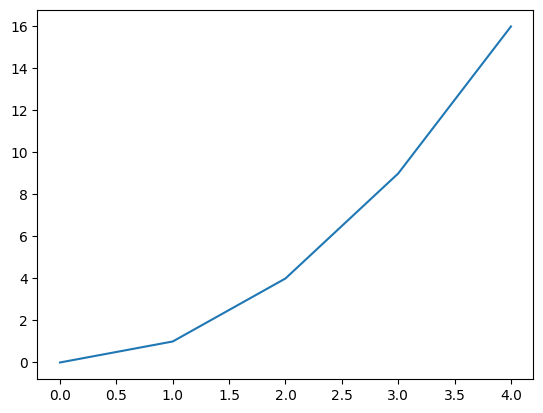

In [25]:
# 创建实时绘制横纵轴变量
x = []
y = []
# 创建绘制实时损失的动态窗口
plt.ion()

# 创建循环
for i in range(5):
    x.append(i)# 添加i到x轴的数据中
    y.append(i**2)# 添加i的平方到y轴的数据中
    plt.clf()  # 清除之前画的图
    plt.plot(x, y * np.array([1]))  # 画出当前x列表和y列表中的值的图形
    plt.pause(0.001)  # 暂停一段时间，不然画的太快会卡住显示不出来
    display.clear_output(wait=True)
    plt.ioff()  # 关闭画图窗口


[2023-09-07 00:18:53,980] [    INFO] 1868144105.py:9 - 4


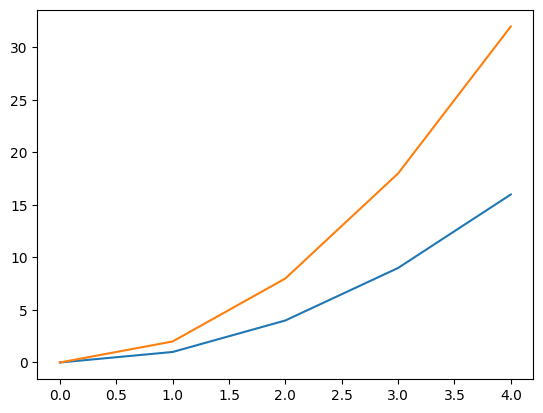

In [15]:
# 创建实时绘制横纵轴变量
x = []
y = []
# 创建绘制实时损失的动态窗口
plt.ion()

# 创建循环
for i in range(5):
    logger.info(i)
    x.append(i)# 添加i到x轴的数据中
    y.append(i**2)# 添加i的平方到y轴的数据中
    plt.clf()  # 清除之前画的图
    plt.plot(x, y * np.array([1]))  # 画出当前x列表和y列表中的值的图形
    plt.plot(x, y * np.array([2]))
    plt.pause(0.001)  # 暂停一段时间，不然画的太快会卡住显示不出来
    display.clear_output(wait=True)
    plt.ioff()  # 关闭画图窗口
